# Wikipedia Thanks-Receiver Study Randomization 
[J. Nathan Matias](https://twitter.com/natematias)
October 29, 2019

This code takes as input data described in the [randomization data format](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit?usp=drive_web&ouid=117701977297551627494) and produces randomizations for the Thanks Recipient study.

Notes:
* We use the 99% confidence interval cutoffs from our first sample rather than relative to each subsequent sample
    * Polish Experienced: 235.380736142341
    * Polish Newcomer: 72.2118047599678
    * Arabic Newcomer: 54.7365066602131
    * German Newcomer: 63.3678642498622
* We will be drawing only 300 Polish accounts

In [1]:
options("scipen"=9, "digits"=4)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(blockTools)
library(blockrand)
library(gmodels) # contains CrossTable
library(DeclareDesign)
library(DescTools) # contains Freq
library(uuid)
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.2.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::as_function() masks rlang::as_function()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::invoke()      masks rlang::invoke()
✖ dplyr::lag()         masks stats::lag()
✖ purrr::list_along()  masks rlang::list_along()
✖ purrr::modify()      masks rlang::modify()
✖ purrr::rep_along()   masks rlang::rep_along()
✖ purrr::splice()      masks rlang::spl

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] uuid_0.1-2           DescTools_0.99.28    DeclareDesign_0.12.0
 [4] estimatr_0.14        fabricatr_0.6.0      randomizr_0.16.1    
 [7] gmodels_2.18.1       blockrand_1.3        blockTools_0.6-3    
[10] viridis_0.5.1        viridisLite_0.3.0    forcats_0.3.0       
[13] stringr_1.3.1        dpl

# Load Input Dataframe

In [2]:
filename <- "all-thankees-historical-20191029.csv"
data.path <- "/home/civilservant/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thankee"
recipient.df <- read.csv(file.path(data.path, "historical_output", filename))

### Load Participants in the Thanker Study

In [3]:
thanker.df <- read.csv(file.path(data.path, "..", "thanker_hardlaunch", "randomization_output",
                                 "all-thanker-randomization-final-20190729.csv"))
usernames.to.exclude <- thanker.df$user_name

###  Load Liaison Usernames

In [4]:
liaison.df <- read.csv(file.path(data.path, "..", "thanker_hardlaunch", "randomization_output",
                                 "liason-thanker-randomization-datadrill-20190718.csv"))

In [5]:
usernames.to.exclude <- append(as.character(usernames.to.exclude), as.character(liaison.df$user_name))
print(paste(length(usernames.to.exclude), "usernames to exclude"))

[1] "462 usernames to exclude"


### Adjust Column Names to Match Thankee Randomization Specification

In [6]:
recipient.df$prev_experience <- factor(as.integer(gsub("bin_", "", recipient.df$prev_experience)))
recipient.df$anonymized_id <- sapply( seq_along(1:nrow(recipient.df)), UUIDgenerate )
recipient.df$newcomer <- recipient.df$prev_experience == 0 
recipient.df <- subset(recipient.df, lang!="en")
#recipient.df <- subset(recipient.df, user_editcount_quality >=4 )

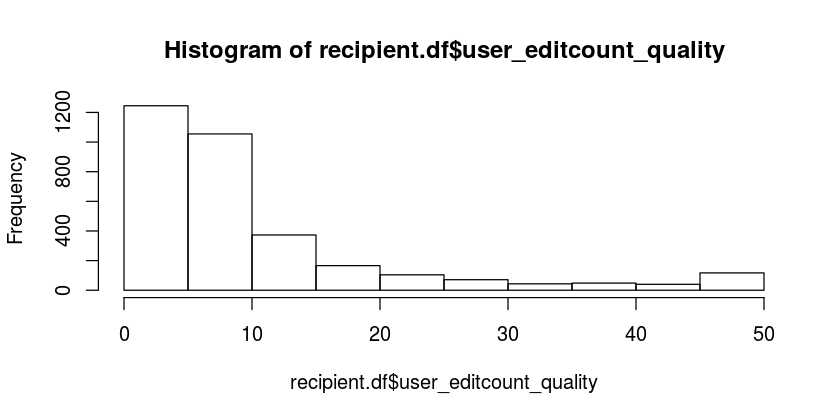

In [7]:
hist(recipient.df$user_editcount_quality)

# Confirm the number of participants

In [8]:
print("Newcomer Participants to Randomize")
summary(subset(recipient.df, newcomer == 1)$lang)

[1] "Newcomer Participants to Randomize"


ar   de   pl 
 743 1565  442

In [9]:
## Polish Experienced Accounts
print("Experienced Participants to Randomize")
summary(subset(recipient.df, newcomer == 0)$lang)

[1] "Experienced Participants to Randomize"


ar  de  pl 
  0   0 512

# Omit Participants

### Omit Participants in the Thanker Study

In [10]:
print(paste(nrow(recipient.df), "participants before removing thankers"))
recipient.df <- subset(recipient.df, (user_name %in% usernames.to.exclude)!=TRUE)
print(paste(nrow(recipient.df), "participants after removing thankers"))                                      

[1] "3262 participants before removing thankers"
[1] "3262 participants after removing thankers"


### Subset values outside the 99% confidence intervals
We are using upper confidence intervals from the first randomization, found at [generate-wikipedia-thanks-recipient-randomizations-final-07.28.3019](generate-wikipedia-thanks-recipient-randomizations-final-07.28.3019.R.ipynb)
    * Polish Experienced: 235.380736142341
    * Polish Newcomer: 72.2118047599678
    * Arabic Newcomer: 54.7365066602131
    * German Newcomer: 63.3678642498622

In [11]:
upper.conf.ints <- data.frame(lang=c("pl", "pl", "de", "ar"),
                              newcomer=c(0,1,1,1),
                              conf.int = c(
                                  235.380736142341,
                                  72.2118047599678,
                                  54.7365066602131,
                                  63.3678642498622
                              ))

In [12]:
upper.conf.ints
#subset(upper.conf.ints, lang=="pl" & newcomer ==1)$conf.int

lang,newcomer,conf.int
pl,0,235.38
pl,1,72.21
de,1,54.74
ar,1,63.37


In [13]:
## CREATE A PLACEHOLDER WITH ZERO ROWS
## BEFORE ITERATING
recipient.trimmed.df <- recipient.df[0,]

for(l in c("ar", "de", "fa", "pl")){
    print(paste("Language: ", l))
    for(n in c(0,1)){
        print(paste("  newcomer:", n == 1))
        lang.df <- subset(recipient.df, lang==l & newcomer == n)
        print(paste( "     ", nrow(lang.df), "rows from original dataset"))
        prev.conf.int <- subset(upper.conf.ints, lang==l & newcomer ==n)$conf.int

        print(      "      99% confidence intervals:")
        print(paste("          upper: ", prev.conf.int ,sep=""))
        
        print(paste("      Removing", 
            nrow(subset(lang.df,
                        labor_hours_84_days_pre_sample > prev.conf.int)), "outliers",
           "observations because labor_hours_84_days_pre_sample is an outlier."))
        lang.subset.df <- subset(lang.df, labor_hours_84_days_pre_sample <= prev.conf.int)
        print(paste( "     ", nrow(lang.subset.df), "rows in trimmed dataset"))
        recipient.trimmed.df <- rbind(recipient.trimmed.df, lang.subset.df)
    }
}

recipient.df.penultimate <- recipient.trimmed.df

[1] "Language:  ar"
[1] "  newcomer: FALSE"
[1] "      0 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: "
[1] "      Removing 0 outliers observations because labor_hours_84_days_pre_sample is an outlier."
[1] "      0 rows in trimmed dataset"
[1] "  newcomer: TRUE"
[1] "      743 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: 63.3678642498622"
[1] "      Removing 8 outliers observations because labor_hours_84_days_pre_sample is an outlier."
[1] "      735 rows in trimmed dataset"
[1] "Language:  de"
[1] "  newcomer: FALSE"
[1] "      0 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: "
[1] "      Removing 0 outliers observations because labor_hours_84_days_pre_sample is an outlier."
[1] "      0 rows in trimmed dataset"
[1] "  newcomer: TRUE"
[1] "      1565 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: 54.7365066602131"
[1] 

# Review and Generate Variables

In [14]:
print(aggregate(recipient.df.penultimate[c("labor_hours_84_days_pre_sample")],
          FUN=mean, by = list(recipient.df.penultimate$prev_experience)))

  Group.1 labor_hours_84_days_pre_sample
1       0                          5.878
2      90                          4.519
3     180                          8.063
4     365                          5.797
5     730                          5.354
6    1460                          5.866
7    2920                          8.791


In [15]:
print(CrossTable(recipient.df.penultimate$has_email, recipient.df.penultimate$newcomer, 
       prop.r = FALSE, prop.c=TRUE, prop.t = FALSE, prop.chisq = FALSE))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  3209 

 
                                   | recipient.df.penultimate$newcomer 
recipient.df.penultimate$has_email |     FALSE |      TRUE | Row Total | 
-----------------------------------|-----------|-----------|-----------|
                             False |        20 |        18 |        38 | 
                                   |     0.039 |     0.007 |           | 
-----------------------------------|-----------|-----------|-----------|
                              True |       491 |      2680 |      3171 | 
                                   |     0.961 |     0.993 |           | 
-----------------------------------|-----------|-----------|-----------|
                      Column Total |       511 |      2698 |      3209 | 
                                   |     0.159 |     0.841 |           | 
-----------------

In [16]:
## Update the has_email field
## recipient.df.penultimate$has_email <- recipient.df.penultimate$has_email == "True"

## PREVIOUS EXPERIENCE
print("prev_experience")
print(summary(factor(recipient.df.penultimate$prev_experience)))
cat("\n")

## SHOW LABOR HOURS BY EXPERIENCE GROUP:
print("Aggregate labor_hours_84_days_pre_sample")
print(aggregate(recipient.df.penultimate[c("labor_hours_84_days_pre_sample")],
          FUN=mean, by = list(recipient.df.penultimate$prev_experience)))
cat("\n")

print("NEWCOMERS AND EMAILS")
print("--------------------")
print(CrossTable(recipient.df.penultimate$has_email, recipient.df.penultimate$newcomer, 
       prop.r = FALSE, prop.c=TRUE, prop.t = FALSE, prop.chisq = FALSE))

# VARIABLE: num_prev_thanks_pre_treatment
print("num_prev_thanks_pre_sample")
print(summary(recipient.df.penultimate$num_prev_thanks_pre_sample))
cat("\n")
    
## SHOW PREVIOUS THANKS BY EXPERIENCE GROUP:
print("num_prev_thanks_pre_sample by prev_experience")
print(aggregate(recipient.df.penultimate[c("num_prev_thanks_pre_sample")],
      FUN=mean, by = list(recipient.df.penultimate$prev_experience)))
cat("\n")

[1] "prev_experience"
   0   90  180  365  730 1460 2920 
2698   63   52   69   81  102  144 

[1] "Aggregate labor_hours_84_days_pre_sample"
  Group.1 labor_hours_84_days_pre_sample
1       0                          5.878
2      90                          4.519
3     180                          8.063
4     365                          5.797
5     730                          5.354
6    1460                          5.866
7    2920                          8.791

[1] "NEWCOMERS AND EMAILS"
[1] "--------------------"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  3209 

 
                                   | recipient.df.penultimate$newcomer 
recipient.df.penultimate$has_email |     FALSE |      TRUE | Row Total | 
-----------------------------------|-----------|-----------|-----------|
                             False |        20 |        18 |        38 | 
        

# Subset Sample to Planned sample sizes
Sample sizes are reported in the experiment [Decisions Document](https://docs.google.com/document/d/1HryhsmWI6WthXQC7zv9Hz1a9DhpZ3FxVRLjTONuMg4I/edit)

* Arabic newcomers (1750 goal) (hoping for as many as possible in first sample)
    * hoping for 1350 in the first sample and 400 later
* German newcomers (3000 goal) (hoping for as many as possible in first sample)
    * hoping for 1600 in first sample and 1400 later
* Persian Experienced (2400 goal)
* Polish:
    * Newcomers: (800 goal)
    * Experienced: (2400 goal)

In [17]:
## Seed generated by Brooklyn Integers
# https://www.brooklynintegers.com/int/1495265601/
set.seed(1495265601)

In [18]:
print("Newcomers")
summary(subset(recipient.df.penultimate, newcomer==1)$lang)

[1] "Newcomers"


ar   de   pl 
 735 1528  435

In [19]:
print("Experienced")
summary(subset(recipient.df.penultimate, newcomer==0)$lang)

[1] "Experienced"


ar  de  pl 
  0   0 511

In [20]:
## CREATE THE FINAL PARTICIPANT SAMPLE BEFORE RANDOMIZATION
recipient.df.final <- recipient.df.penultimate

# Generate Randomization Blocks

In [21]:
recipient.df.final$lang_prev_experience <- factor(paste(recipient.df.final$lang, recipient.df.final$prev_experience))
colnames(recipient.df.final)

[1] "id"                             "created_at"                    
 [3] "lang"                           "user_id"                       
 [5] "user_name"                      "user_registration"             
 [7] "user_editcount"                 "user_editcount_quality"        
 [9] "prev_experience"                "thanks_sent"                   
[11] "num_prev_thanks"                "num_prev_thanks_90"            
[13] "num_prev_thanks_pre_sample"     "labor_hours_84_days_pre_sample"
[15] "has_email"                      "user_completed"                
[17] "user_included"                  "anonymized_id"                 
[19] "newcomer"                       "lang_prev_experience"

In [22]:
## BLOCKING VARIABLES
bv = c("labor_hours_84_days_pre_sample", "num_prev_thanks_pre_sample")

block.size = 2

## TODO: CHECK TO SEE IF I CAN DO BALANCED RANDOMIZATION
## WITHIN BLOCKS LARGER THAN 2
blockobj = block(data=recipient.df.final,
            n.tr = block.size,
            groups = "lang_prev_experience",
            id.vars="anonymized_id",
            block.vars = bv,
            distance ="mahalanobis"
            )
## CHECK DISTANCES
#print(blockobj)
recipient.df.final$randomization_block_id <- createBlockIDs(blockobj,
                                   data=recipient.df.final,
                                   id.var = "anonymized_id")
recipient.df.final$randomization_block_size = block.size

### Identify Incomplete Blocks and Remove Participants in Incomplete Blocks From the Experiment

In [23]:
block.sizes <- aggregate(recipient.df.final$randomization_block_id, FUN=length, by=list(recipient.df.final$randomization_block_id))
incomplete.blocks <- subset(block.sizes, x == 1)$Group.1
incomplete.blocks

[1]  368 1350 1534 1575 1607

In [24]:
nrow(subset(recipient.df.final, randomization_block_id %in% incomplete.blocks))

[1] 5

In [25]:
removed.observations <- subset(recipient.df.final, (
    randomization_block_id %in% incomplete.blocks)==TRUE)

recipient.df.final <- 
    subset(recipient.df.final, (
        randomization_block_id %in% incomplete.blocks)!=TRUE)

print(paste("Removed", nrow(removed.observations), "units placed in incomplete blocks."))

[1] "Removed 5 units placed in incomplete blocks."


# Generate Randomizations

In [26]:
assignments <- block_ra(blocks=recipient.df.final$randomization_block_id, 
                            num_arms = 2, conditions = c(0,1))
recipient.df.final$randomization_arm <- assignments 

### Check Balance

In [27]:
print("Aggregating labor hours by treatment")
print(aggregate(recipient.df.final[c("labor_hours_84_days_pre_sample")],
          FUN=mean, by = list(recipient.df.final$randomization_arm)))

print("CrossTable of lang by treatment")
CrossTable(recipient.df.final$lang, recipient.df.final$randomization_arm, 
       prop.r = TRUE, prop.c=FALSE, prop.t = FALSE, prop.chisq = FALSE)

print("CrossTable of lang_prev_experience by treatment")
CrossTable(recipient.df.final$lang_prev_experience, recipient.df.final$randomization_arm, 
       prop.r = TRUE, prop.c=FALSE, prop.t = FALSE, prop.chisq = FALSE)


[1] "Aggregating labor hours by treatment"
  Group.1 labor_hours_84_days_pre_sample
1       0                          6.008
2       1                          5.944
[1] "CrossTable of lang by treatment"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  3204 

 
                        | recipient.df.final$randomization_arm 
recipient.df.final$lang |         0 |         1 | Row Total | 
------------------------|-----------|-----------|-----------|
                     ar |       367 |       367 |       734 | 
                        |     0.500 |     0.500 |     0.229 | 
------------------------|-----------|-----------|-----------|
                     de |       764 |       764 |      1528 | 
                        |     0.500 |     0.500 |     0.477 | 
------------------------|-----------|-----------|-----------|
                     pl |       471 |       471 |       9

# Subset Polish Experienced Accounts
Within Polish, identify 300 accounts (150 blocks) to include and drop all of the others.

Note: since the previous randomization included a larger number of more experienced accounts, we're prioritizing accounts from experience groups 90, 180, 365, 730, and 1460 (all except 2920). 

In [28]:
## SHOW PREVIOUS THANKS BY EXPERIENCE GROUP:
recipient.df.final$count.var <- 1
print("Number of Accounts for each experience level among Polish Participants")
print(aggregate(subset(recipient.df.final, lang="pl")[c("count.var")],
      FUN=sum, by = list(subset(recipient.df.final, lang="pl")$prev_experience)))
cat("\n")

[1] "Number of Accounts for each experience level among Polish Participants"
  Group.1 count.var
1       0      2696
2      90        62
3     180        52
4     365        68
5     730        80
6    1460       102
7    2920       144



In [29]:
print(paste("Total number of rows: ", nrow(recipient.df.final), sep=""))

recipient.df.final.a <- subset(recipient.df.final, !(lang=="pl" & prev_experience==2920))
recipient.df.final.a$initial.block.id <- recipient.df.final.a$randomization_block_id
print(paste("Total number of rows once we subset Polish:", nrow(recipient.df.final.a)))

[1] "Total number of rows: 3204"
[1] "Total number of rows once we subset Polish: 3060"


### Offset block IDs to be unique
Observe the block IDs from the previous randomizations and ensure that these ones are unique and larger.

In [30]:
## LOAD PREVIOUS RANDOMIZATIONS
prev_randomization_filename <- "thanks-recipient-randomizations-20190729.csv"
prev.randomization.df <- read.csv(file.path(data.path, "randomization_output", prev_randomization_filename))
print(paste("Max Block ID: ", max(prev.randomization.df$randomization_block_id)))
prev.max.block.id <- max(prev.randomization.df$randomization_block_id)
prev.max.block.id <- 4221

[1] "Max Block ID:  3707"


In [31]:
recipient.df.final.a$randomization_block_id <- recipient.df.final.a$initial.block.id + prev.max.block.id
summary(recipient.df.final.a$randomization_block_id)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4222    4605    4988    4992    5370    5827 

### Sort by block ID

In [32]:
recipient.df.final.a <- recipient.df.final.a[order(recipient.df.final.a$randomization_block_id),]

In [33]:
print("Newcomers")
summary(subset(recipient.df.final.a, newcomer==1)$lang)
print("Experienced")
summary(subset(recipient.df.final.a, newcomer==0)$lang)

[1] "Newcomers"


ar   de   pl 
 734 1528  434

[1] "Experienced"


ar  de  pl 
  0   0 364

# Output and Archive Randomizations

In [34]:
randomization.filename <- paste("thanks-recipient-randomizations-", format(Sys.Date(), format="%Y%m%d"), ".csv", sep="") 
write.csv(recipient.df.final.a, file = file.path(data.path, "randomization_output", randomization.filename))

In [36]:
colnames(recipient.df.final.a)

[1] "id"                             "created_at"                    
 [3] "lang"                           "user_id"                       
 [5] "user_name"                      "user_registration"             
 [7] "user_editcount"                 "user_editcount_quality"        
 [9] "prev_experience"                "thanks_sent"                   
[11] "num_prev_thanks"                "num_prev_thanks_90"            
[13] "num_prev_thanks_pre_sample"     "labor_hours_84_days_pre_sample"
[15] "has_email"                      "user_completed"                
[17] "user_included"                  "anonymized_id"                 
[19] "newcomer"                       "lang_prev_experience"          
[21] "randomization_block_id"         "randomization_block_size"      
[23] "randomization_arm"              "count.var"                     
[25] "initial.block.id"